In [33]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [34]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [35]:
! nvidia-smi

Mon Jun 13 00:05:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 27%   35C    P8    21W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 25%   

# MongoDB

In [36]:
from pymongo import MongoClient
import pymongo

In [37]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_de = db.patent_de
    # db_us = db.patent_us
    # db_cn = db.patent_cn

    db_rm_cn_2016 = db.rm_patent_cn_2016
    db_rm_us_2016 = db.rm_patent_us_2016
    db_rm_de_2016 = db.rm_patent_de_2016

    
except errors.ConnectionFailure as err:
    print(err)

# 2016

## Company數量

In [38]:
data_assignee = db_rm_de_2016.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [39]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [40]:
data_assignee = db_rm_cn_2016.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [41]:
data_assignee = db_rm_us_2016.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [42]:
final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

In [43]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
61,Samsung Electronics Co Ltd,775
36,Intel Corp,279
54,Qualcomm Inc,196
71,Telefonaktiebolaget LM Ericsson AB,166
34,Huawei Technologies Co Ltd,132
79,ZTE Corp,117
42,LG Electronics Inc,92
38,International Business Machines Corp,89
17,Cisco Technology Inc,88
2,Anhui Sharetronic Iot Technology Co Ltd,85


In [44]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df.reset_index(drop=True, inplace=True)

In [45]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,Samsung Electronics Co Ltd,775,6.652863
1,Intel Corp,279,5.631212
2,Qualcomm Inc,196,5.278115
3,Telefonaktiebolaget LM Ericsson AB,166,5.111988
4,Huawei Technologies Co Ltd,132,4.882802
5,ZTE Corp,117,4.762174
6,LG Electronics Inc,92,4.521789
7,International Business Machines Corp,89,4.488636
8,Cisco Technology Inc,88,4.477337
9,Anhui Sharetronic Iot Technology Co Ltd,85,4.442651


In [46]:
com_ls = list(com_df.company)

## Data

In [47]:
ccontry = pd.read_csv("./final_data/rm_company_country_all_2016.csv")
ccpc = pd.read_csv("./final_data/rm_company_cpc_all_2016.csv")

In [48]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AR,AT,AU,BR,CA,CL,CN,CO,DE,...,RS,RU,SE,SG,SI,TN,TW,US,UY,ZA
67,Anhui Sharetronic Iot Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,85.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274,Cisco Technology Inc,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,0.0,0.0
615,Huawei Technologies Co Ltd,0.0,0.0,4.0,15.0,3.0,0.0,132.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,77.0,0.0,2.0
687,Intel Corp,0.0,0.0,0.0,3.0,0.0,0.0,62.0,0.0,39.0,...,0.0,2.0,0.0,1.0,0.0,0.0,21.0,303.0,0.0,0.0
696,International Business Machines Corp,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.0,0.0,0.0


## Similarity計算

### Country

- 換成機率  

In [49]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [50]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AR,AT,AU,BR,CA,CL,CN,CO,DE,DK,...,RS,RU,SE,SG,SI,TN,TW,US,UY,ZA
company,,,,,,,,,,,,,,,,,,,,,
Samsung Electronics Co Ltd,0.000000,0.0,0.003641,0.001365,0.001365,0.000000,0.172508,0.000000,0.008648,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0000,0.009103,0.362767,0.0,0.000000
Intel Corp,0.000000,0.0,0.000000,0.005952,0.000000,0.000000,0.123016,0.000000,0.077381,0.000000,...,0.0,0.003968,0.0,0.001984,0.000000,0.0000,0.041667,0.601190,0.0,0.000000
Qualcomm Inc,0.001200,0.0,0.034814,0.086435,0.030012,0.007203,0.142857,0.007203,0.000000,0.004802,...,0.0,0.009604,0.0,0.009604,0.004802,0.0012,0.063625,0.231693,0.0,0.006002
Telefonaktiebolaget LM Ericsson AB,0.020183,0.0,0.012844,0.022018,0.018349,0.000000,0.135780,0.001835,0.000000,0.011009,...,0.0,0.034862,0.0,0.000000,0.000000,0.0000,0.001835,0.299083,0.0,0.016514
Huawei Technologies Co Ltd,0.000000,0.0,0.011461,0.042980,0.008596,0.000000,0.378223,0.000000,0.000000,0.000000,...,0.0,0.005731,0.0,0.000000,0.000000,0.0000,0.000000,0.220630,0.0,0.005731


In [51]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [52]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [53]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [54]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [55]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

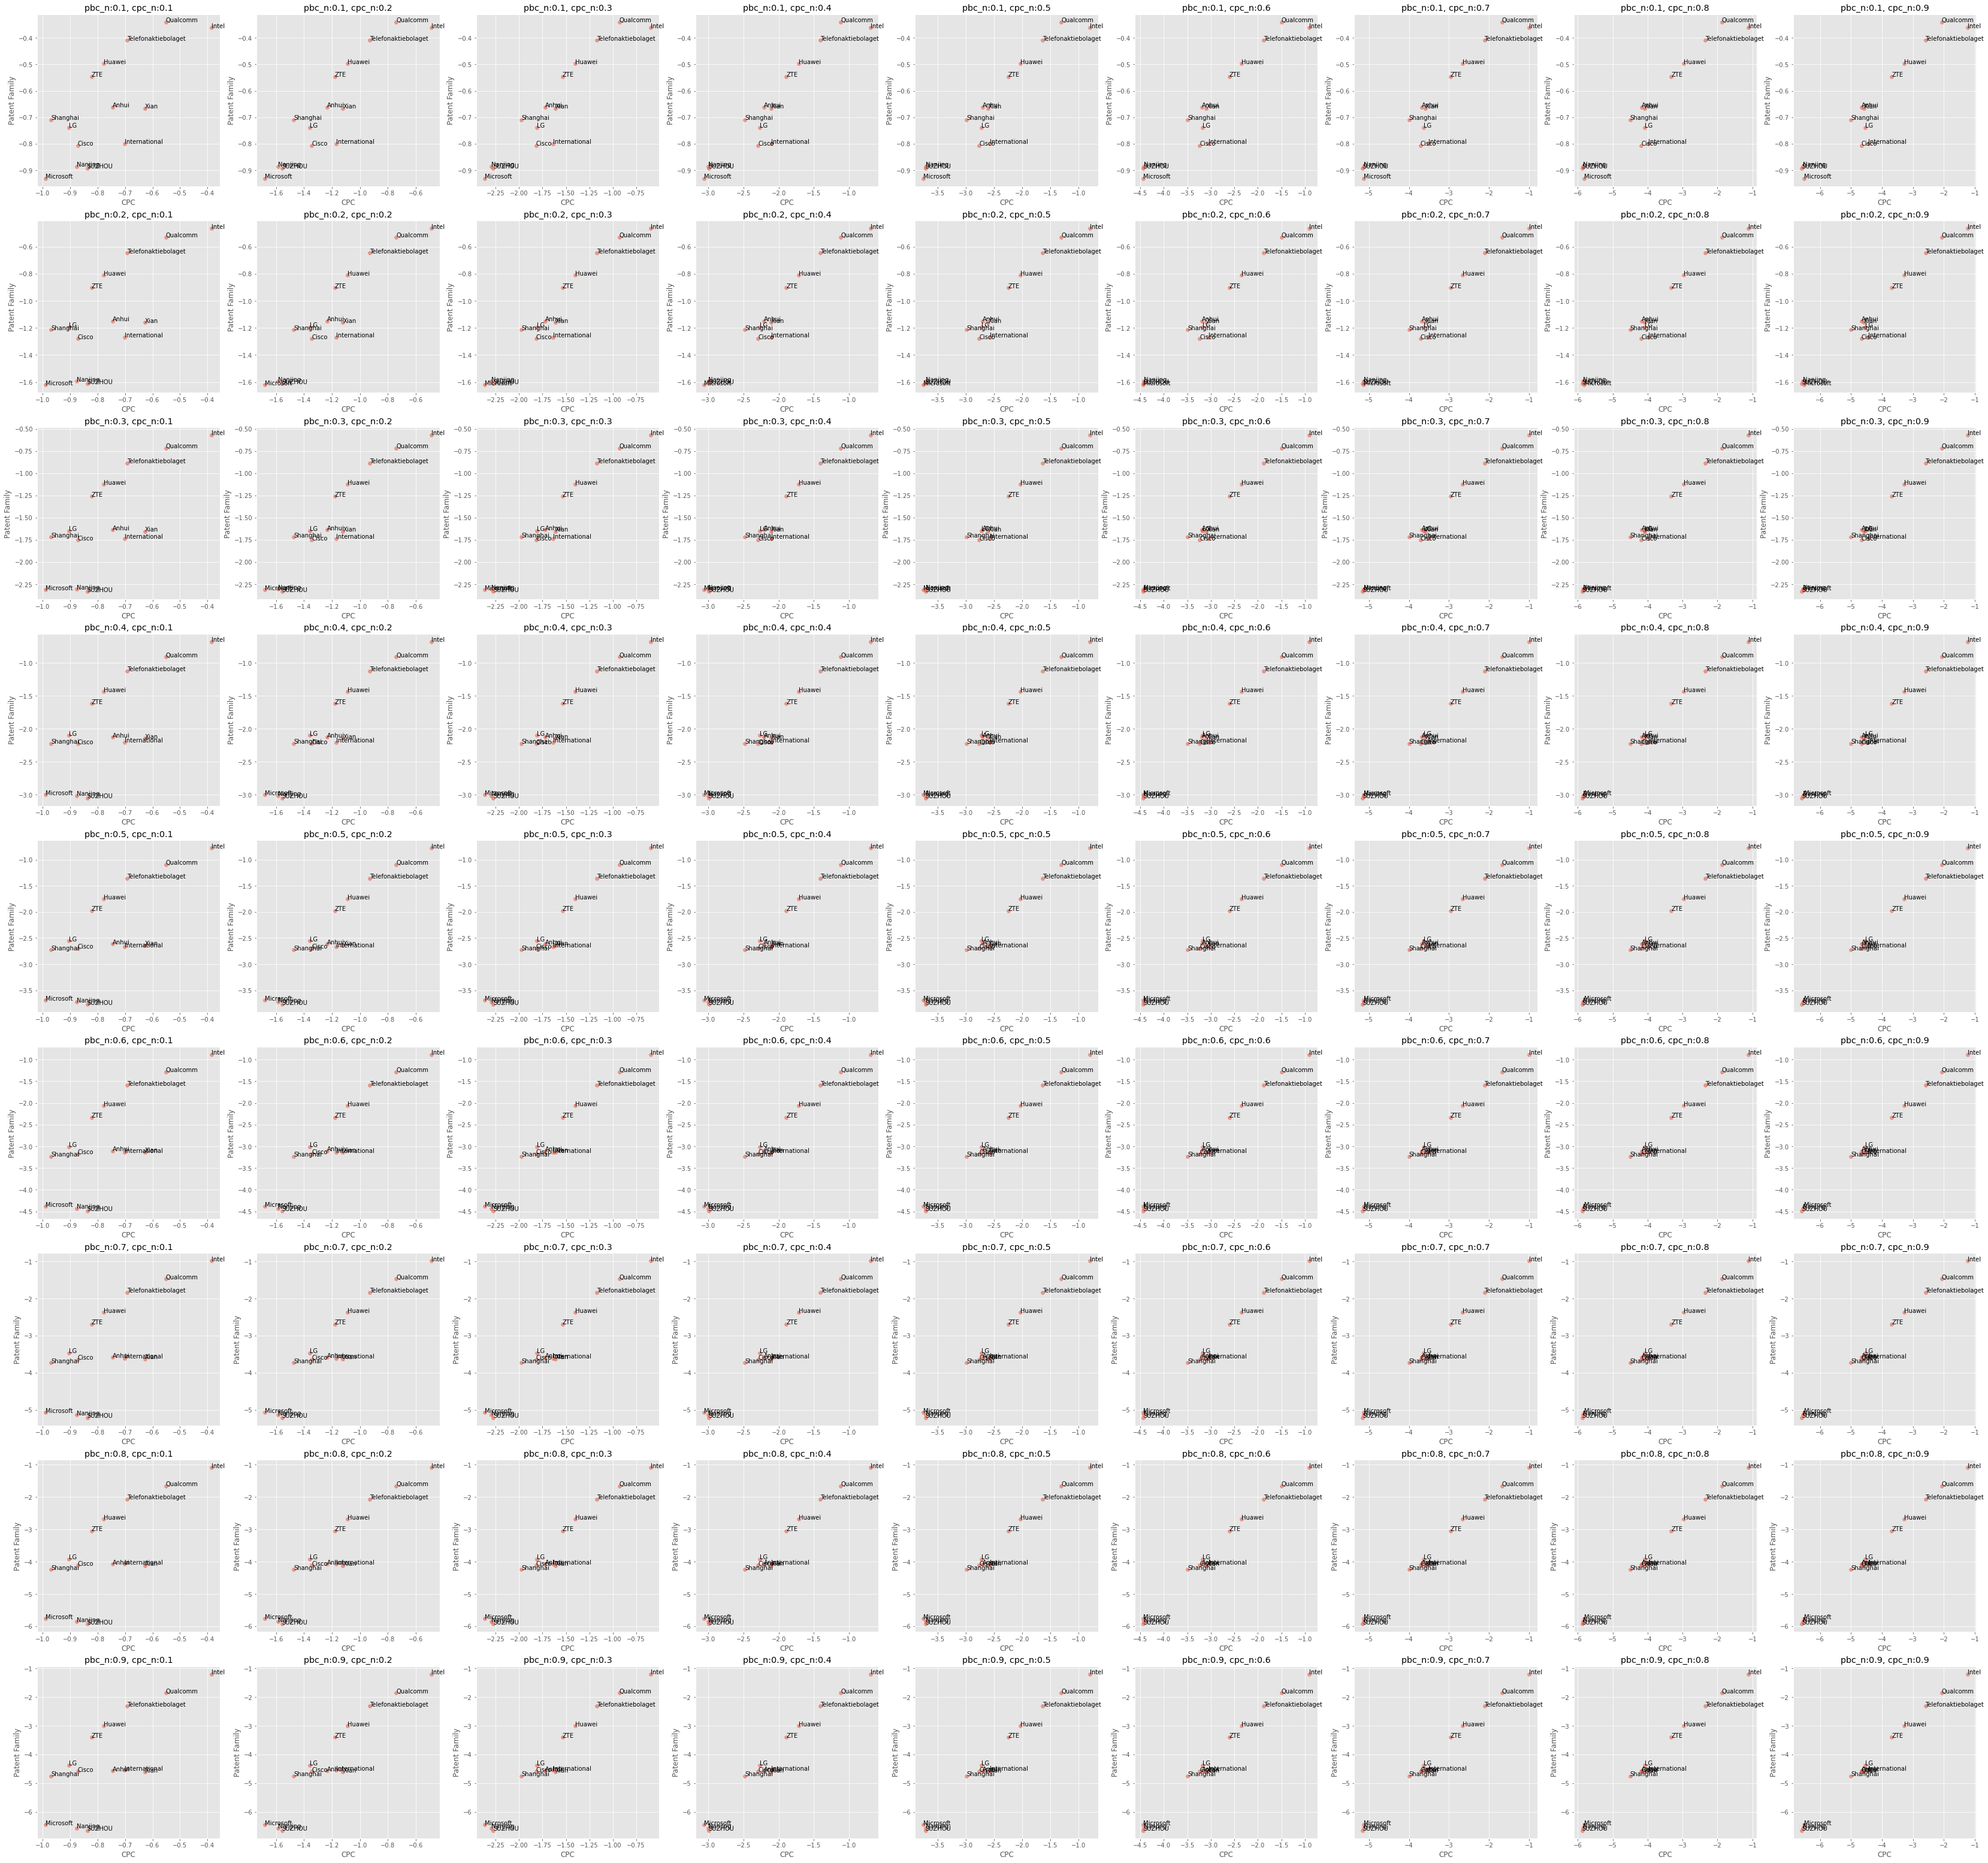

In [56]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2016_1.png'.format(pbc_n))

In [57]:
c_df

,cpc,country
company,,
Intel Corp,1.219624,1.195886
Qualcomm Inc,2.063728,1.851503
Telefonaktiebolaget LM Ericsson AB,2.592500,2.308698
Huawei Technologies Co Ltd,3.283245,3.003805
ZTE Corp,3.681026,3.405833
LG Electronics Inc,4.537637,4.371681
International Business Machines Corp,4.449351,4.546590
Cisco Technology Inc,4.658591,4.592989
Anhui Sharetronic Iot Technology Co Ltd,4.652572,4.569040


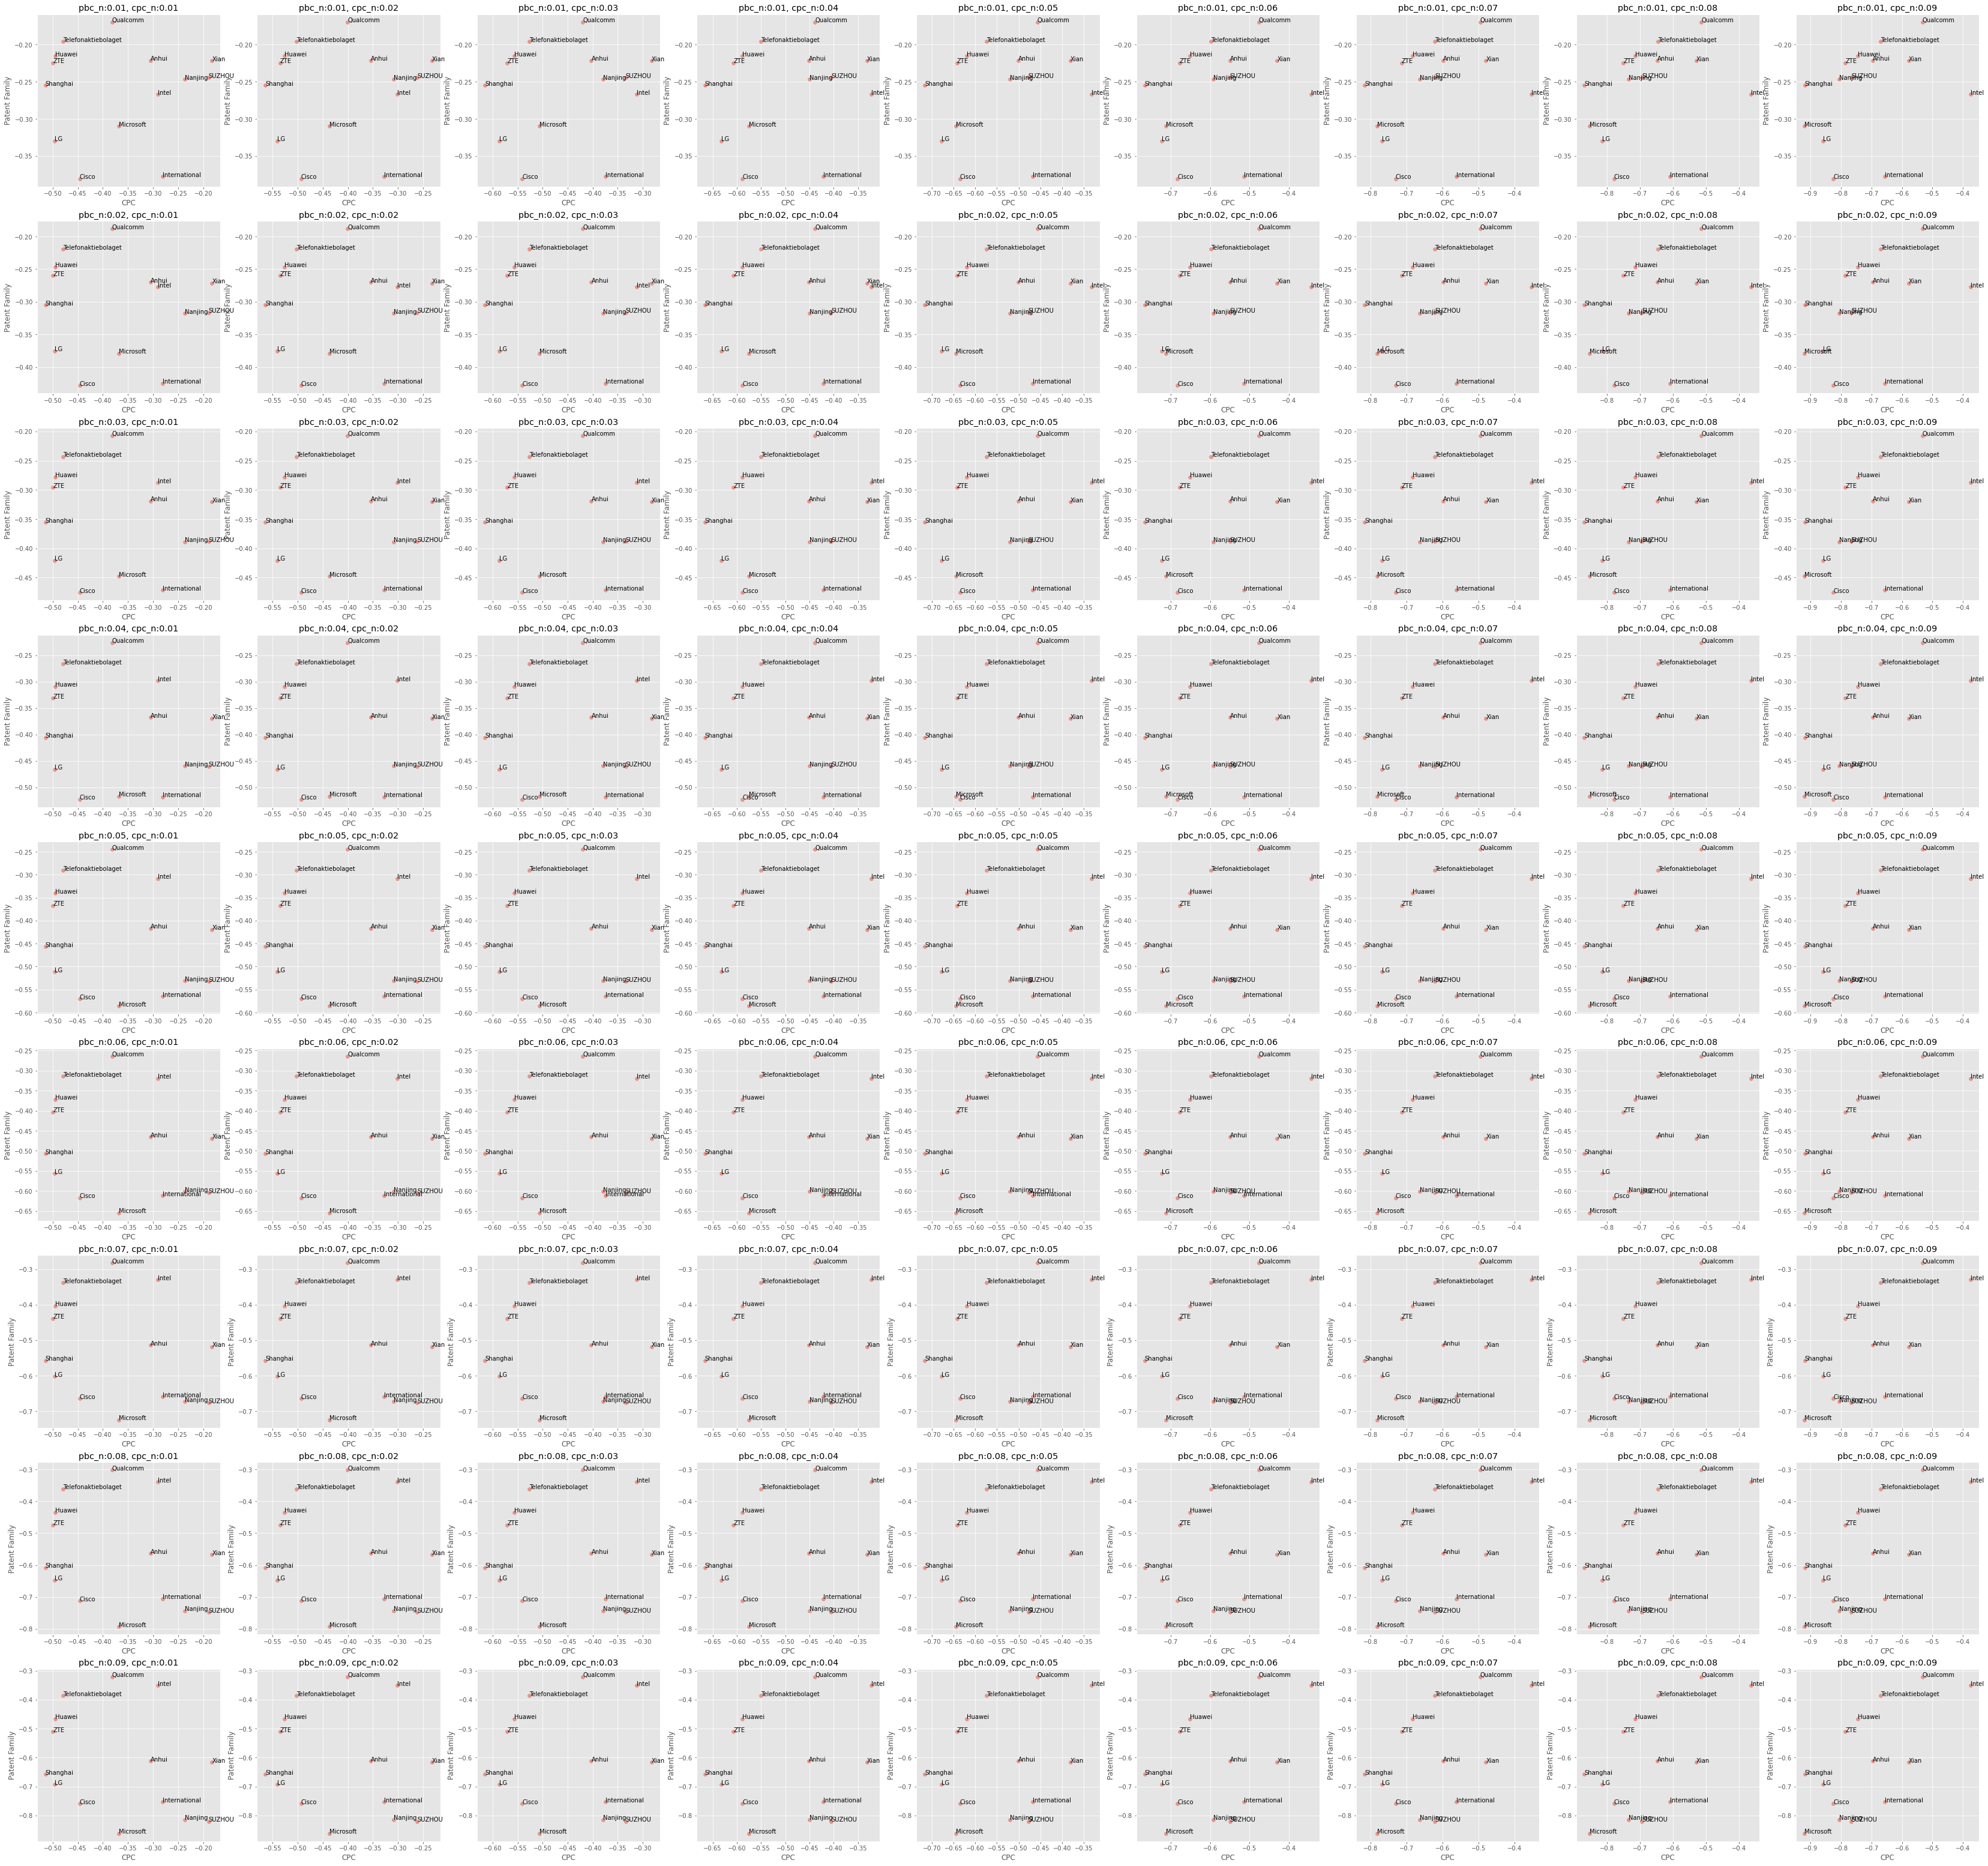

In [58]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2016_2.png'.format(pbc_n))

In [59]:
c_df

,cpc,country
company,,
Intel Corp,0.374170,0.350431
Qualcomm Inc,0.532883,0.320657
Telefonaktiebolaget LM Ericsson AB,0.669320,0.385517
Huawei Technologies Co Ltd,0.745421,0.465981
ZTE Corp,0.785514,0.510322
LG Electronics Inc,0.859039,0.693083
International Business Machines Corp,0.655411,0.752650
Cisco Technology Inc,0.824930,0.759329
Anhui Sharetronic Iot Technology Co Ltd,0.695692,0.612161


In [60]:
c_df = scatter_plot(pbc_n,cpc_n)
c_df = c_df.reset_index()
c_df["company"] = c_df.company.apply(lambda x: x.replace(" Inc","")\
                                                    .replace(" Co Ltd","")\
                                                    .replace(" Co. Ltd.","")\
                                                    .replace(" Co., Ltd.","")\
                                                    .replace(" Ltd","")\
                                                    .replace(" Corp","")\
                                                    .replace("..","")\
                                                    .replace("International Business Machines","IBM")\
                                                    .replace("Nippon Telegraph and Telephone","Nippon Telegraph & Tel")\
                                                    .replace("Alibaba Group Holding Ltd","Alibaba")\
                                                    .replace("ZTE Intelligent IoT Technology","ZTE")\
                                                    .replace("AT&T Intellectual Property I LP","AT&T")\
                                                    .replace("Microsoft Technology Licensing LLC","Microsoft")\
                                                    .replace("Telefonaktiebolaget LM Ericsson AB","Ericsson")\
                                                    .replace("Cisco Technology","Cisco Systems")\
                                                    .replace("Verizon Patent and Licensing","Verizon Communications")\
                                                    .replace("Nokia Technologies Oy","Nokia")\
                                                    .replace("China Mobile Communications Group","China Mobile")\
                                                    .replace("Nokia Solutions and Networks Oy","Nokia"))
c_df.set_index("company", inplace=True)
c_df = c_df.drop("Samsung Electronics")

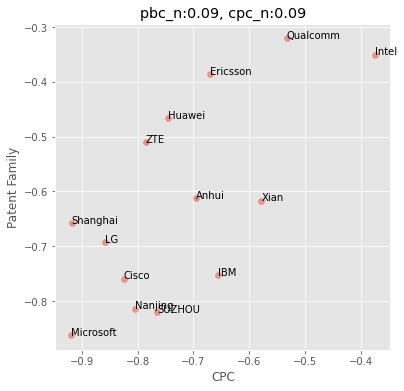

In [61]:
plt.figure(figsize=(6,6))
plt.style.use('ggplot')

pbc_n=0.09
cpc_n=0.09
# c_df = scatter_plot(pbc_n,cpc_n)
# c_df = c_df.drop("Samsung Electronics Co Ltd")

#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [62]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [63]:
competitor_ls

[1, 1, 2, 2, 2, 4, 4, 4, 4, 3, 4, 4, 4, 4]

In [64]:
c_df

,cpc,country
company,,
Intel,0.374170,0.350431
Qualcomm,0.532883,0.320657
Ericsson,0.669320,0.385517
Huawei Technologies,0.745421,0.465981
ZTE,0.785514,0.510322
LG Electronics,0.859039,0.693083
IBM,0.655411,0.752650
Cisco Systems,0.824930,0.759329
Anhui Sharetronic Iot Technology,0.695692,0.612161
